In [2]:
!pip install networkx scipy
!pip install plotly
!pip install pyvis
!pip install scikit-learn scipy seaborn
!pip install -U kaleido
!pip install matplotlib
!pip install pandas
!pip install numpy
!pip install scikit-bio
!pip install qiime2
!pip install qiime2-plugin-diversity
!pip install statannotations scikit-bio


ERROR: Could not find a version that satisfies the requirement qiime2 (from versions: none)
ERROR: No matching distribution found for qiime2
ERROR: Could not find a version that satisfies the requirement qiime2-plugin-diversity (from versions: none)
ERROR: No matching distribution found for qiime2-plugin-diversity


Setup, Style & Colors

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.spatial.distance import pdist, squareform
from skbio.stats.ordination import pcoa
from statannotations.Annotator import Annotator
import os

sns.set_style("ticks")
sns.set_context("paper", font_scale=1.4)

# Define Colors (Teal, Yellow, Red)
MY_PALETTE = {
    "Control": "#e7b9a0",                  # NC
    "Atopic_dermatitis_non_lesion": "#a7d3a4", # AD-NL
    "Atopic_dermatitis_lesion": "#92a4cf"   # AD-L
}

# Define Group Order & Labels
ORDER = ["Control", "Atopic_dermatitis_non_lesion", "Atopic_dermatitis_lesion"]
SHORT_LABELS = ["NC", "AD-NL", "AD-L"]

# Paths
INPUT_FILE = "/home/marcos/PRJEB59406/results/Final_Table_Taxonomy_Function.tsv"
OUTPUT_DIR = "/home/marcos/PRJEB59406/figures/pub_quality/"
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("Setup complete. Output directory created.")

Setup complete. Output directory created.


Load Data & Calculate Alpha Diversity

In [4]:
df = pd.read_csv(INPUT_FILE, sep='\t')

# Create readable labels (Genus + ID)
df['Label'] = df.apply(lambda x: x['Species'] if pd.notna(x['Species']) and len(str(x['Species'])) > 3 else f"{x['Genus']} ({x['mag_id']})", axis=1)

# Pivot Table: Rows=Samples, Cols=Bacteria
matrix = df.pivot_table(index='Sample', columns='Label', values='Abundance', fill_value=0)

# Map Samples to Groups
sample_to_group = df.drop_duplicates('Sample').set_index('Sample')['Group'].to_dict()
groups = matrix.index.map(sample_to_group)

# --- CALCULATE ALPHA DIVERSITY ---
def calc_shannon(row):
    """Calculates Shannon Entropy"""
    total = row.sum()
    if total == 0: return 0
    p = row / total
    p = p[p > 0]
    return -np.sum(p * np.log(p))

# Create Alpha DataFrame
alpha_df = pd.DataFrame(index=matrix.index)
alpha_df['Shannon'] = matrix.apply(calc_shannon, axis=1)
alpha_df['Richness'] = (matrix > 0).sum(axis=1) # Count observed species
alpha_df['Group'] = groups

print("Data loaded and Alpha Diversity calculated.")

Data loaded and Alpha Diversity calculated.


Plot Alpha Diversity (Boxplots with Stats)

/tmp/ipykernel_9540/592734362.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data=data, x='Group', y=metric, order=ORDER,
/tmp/ipykernel_9540/592734362.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(SHORT_LABELS)


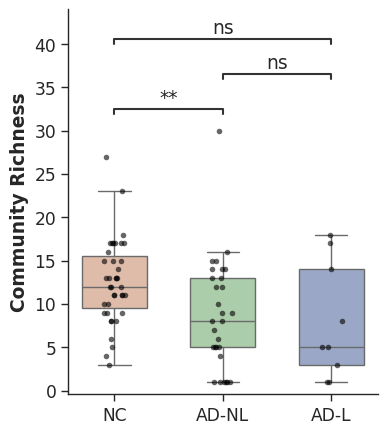

/tmp/ipykernel_9540/592734362.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data=data, x='Group', y=metric, order=ORDER,
/tmp/ipykernel_9540/592734362.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(SHORT_LABELS)


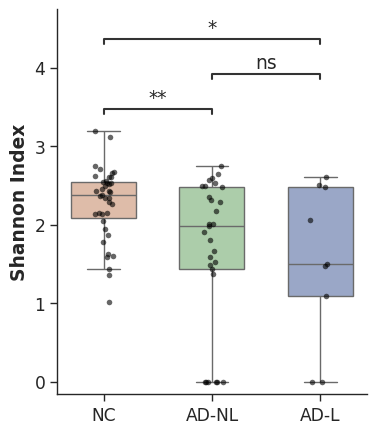

In [5]:
def plot_alpha_panel(data, metric, y_label, filename):
    plt.figure(figsize=(4, 5))
    
    # Plot Boxplot
    ax = sns.boxplot(data=data, x='Group', y=metric, order=ORDER, 
                     palette=MY_PALETTE, width=0.6, fliersize=0)
    
    # Add Jitter Points (Individual Samples)
    sns.stripplot(data=data, x='Group', y=metric, order=ORDER, 
                  color="black", size=4, alpha=0.6, ax=ax)
    
    # Add Statistical Brackets (Mann-Whitney)
    pairs = [("Control", "Atopic_dermatitis_non_lesion"),
             ("Control", "Atopic_dermatitis_lesion"),
             ("Atopic_dermatitis_non_lesion", "Atopic_dermatitis_lesion")]
    
    annotator = Annotator(ax, pairs, data=data, x='Group', y=metric, order=ORDER)
    annotator.configure(test='Mann-Whitney', text_format='star', loc='inside', verbose=False)
    annotator.apply_and_annotate()
    
    # Clean up axes
    ax.set_xlabel("")
    ax.set_ylabel(y_label, fontweight='bold')
    ax.set_xticklabels(SHORT_LABELS)
    
    sns.despine() # Remove top and right borders
    plt.savefig(os.path.join(OUTPUT_DIR, filename), bbox_inches='tight')
    plt.show()

# Generate Plots
plot_alpha_panel(alpha_df, 'Richness', 'Community Richness', 'Fig1a_Richness.svg')
plot_alpha_panel(alpha_df, 'Shannon', 'Shannon Index', 'Fig1b_Shannon.svg')

Plot Beta Diversity (PCoA)

/home/marcos/miniconda3/envs/bowtie2/lib/python3.14/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:157: RuntimeWarning: EIGH: since no value for dimensions is specified, PCoA for all dimensions will be computed, which may result in long computation time if the original distance matrix is large.
  warn(
/home/marcos/miniconda3/envs/bowtie2/lib/python3.14/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:275: RuntimeWarning: The result contains negative eigenvalues that are large in magnitude, which may suggest result inaccuracy. See Notes for details. The negative-most eigenvalue is -0.16309774740989813 whereas the largest positive one is 3.2049511422146977.
  warn(
/tmp/ipykernel_9540/1909244035.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/i

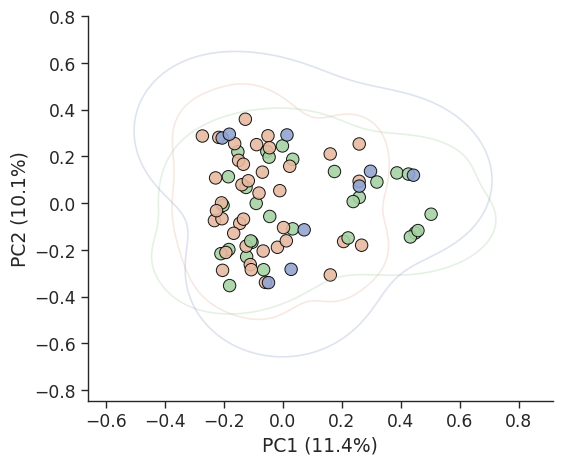

In [6]:
# Calculate Bray-Curtis Distance & PCoA
dist_matrix = pdist(matrix, metric='braycurtis')
pcoa_res = pcoa(squareform(dist_matrix))

# Prepare Plot Data
pcoa_df = pcoa_res.samples[['PC1', 'PC2']]
pcoa_df['Group'] = groups
var_exp = pcoa_res.proportion_explained # Variance explained %

plt.figure(figsize=(6, 5))

# Scatter Plot
sns.scatterplot(data=pcoa_df, x='PC1', y='PC2', hue='Group', hue_order=ORDER,
                palette=MY_PALETTE, s=80, edgecolor='black', alpha=0.9, legend=False)

# Add Density Ellipses (Optional aesthetic)
for g in ORDER:
    subset = pcoa_df[pcoa_df['Group'] == g]
    if len(subset) > 3:
        sns.kdeplot(x=subset['PC1'], y=subset['PC2'], 
                    levels=1, color=MY_PALETTE[g], alpha=0.3)

# Labels with Variance %
plt.xlabel(f"PC1 ({var_exp['PC1']:.1%})")
plt.ylabel(f"PC2 ({var_exp['PC2']:.1%})")

sns.despine()
plt.savefig(os.path.join(OUTPUT_DIR, 'Fig1c_PCoA.svg'), bbox_inches='tight')
plt.show()

Plot Abundance Bars (Top Species)

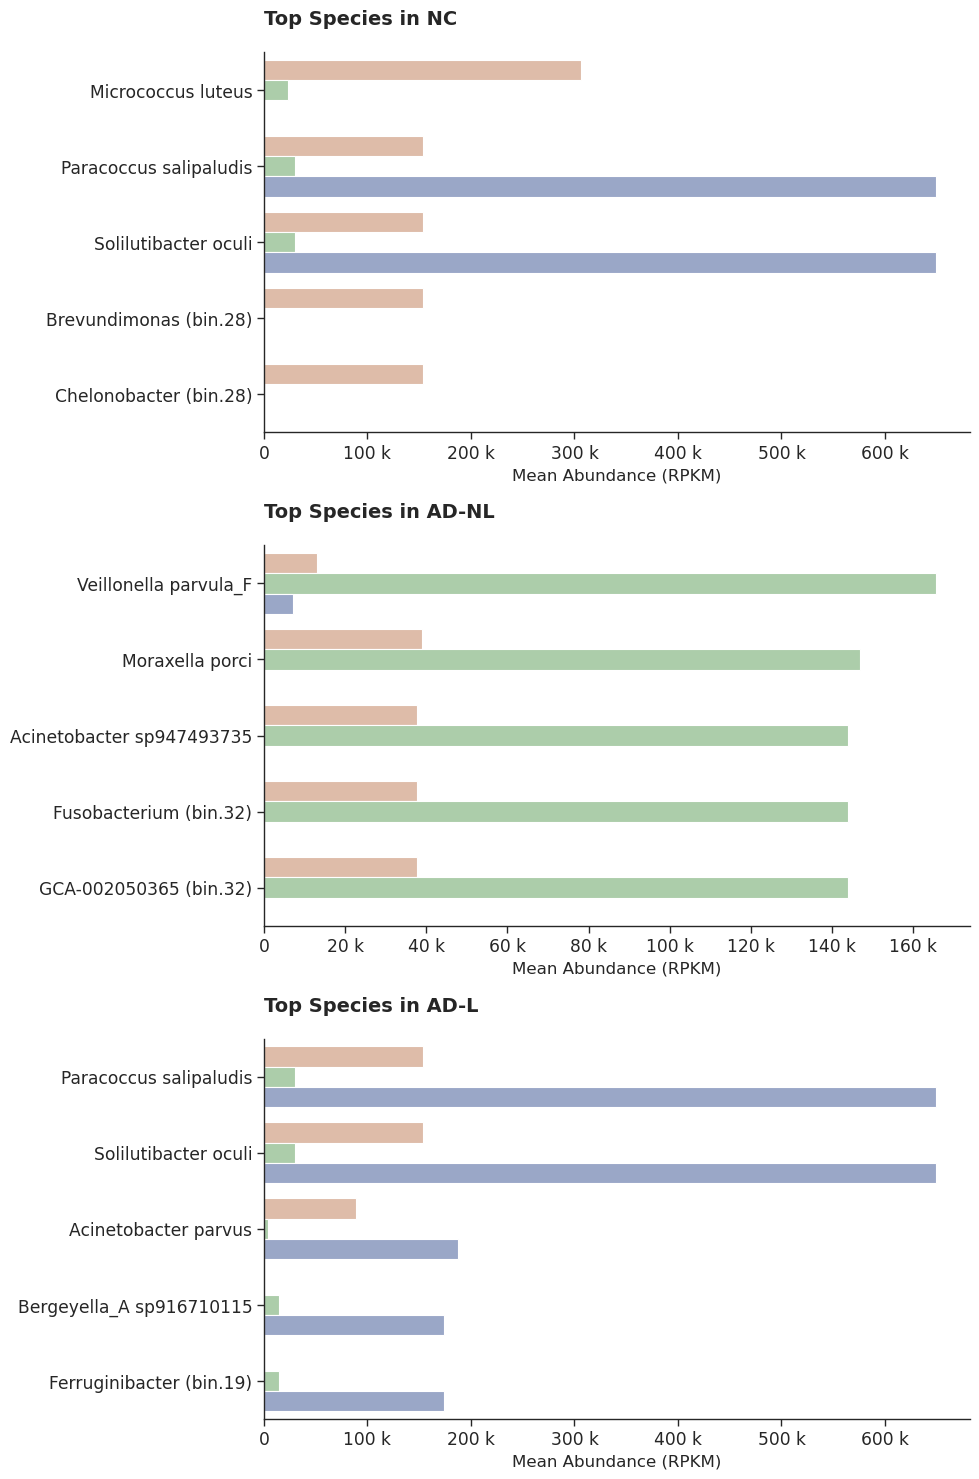

In [ ]:
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches 
import seaborn as sns
import pandas as pd
import os

palette_final = MY_PALETTE
if isinstance(MY_PALETTE, list):
    palette_final = MY_PALETTE[::-1] 

mean_abund = df.groupby(['Group', 'Label'])['Abundance'].mean().reset_index()

fig, axes = plt.subplots(3, 1, figsize=(10, 15), sharex=False)

for i, group in enumerate(ORDER):
    ax = axes[i]
    
    top_5_labels = mean_abund[mean_abund['Group'] == group] \
                   .nlargest(5, 'Abundance')['Label'].tolist()
    
    plot_data = mean_abund[mean_abund['Label'].isin(top_5_labels)]
    
    sns.barplot(data=plot_data, y='Label', x='Abundance', hue='Group', 
                palette=palette_final, 
                order=top_5_labels,
                hue_order=ORDER,       
                dodge=True,
                ax=ax)
    
    ax.xaxis.set_major_formatter(ticker.EngFormatter()) 
    ax.set_title(f"Top Species in {SHORT_LABELS[i]}", fontweight='bold', loc='left', fontsize=14, pad=20)
    ax.set_xlabel("Mean Abundance (RPKM)", fontsize=12)
    ax.set_ylabel("")
    
    if ax.get_legend():
        ax.legend_.remove()

legend_patches = []
for i, group_name in enumerate(ORDER):
    if isinstance(palette_final, dict):
        cor = palette_final.get(group_name, 'grey')
    else:
        cor = palette_final[i] 
        
    label_text = SHORT_LABELS[i] if i < len(SHORT_LABELS) else group_name
    patch = mpatches.Patch(color=cor, label=label_text)
    legend_patches.append(patch)

#fig.legend(handles=legend_patches, 
#           loc='upper center', bbox_to_anchor=(0.5, 1.02), 
#           ncol=3, frameon=False, 
#           fontsize=12,         
#           title_fontsize=16,   
#           title="Group Distribution")

plt.tight_layout() 
sns.despine()

plt.savefig(os.path.join(OUTPUT_DIR, 'Fig1d_Abundance_Panels.svg'), bbox_inches='tight')
plt.show()

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import os

# Re-using the previously loaded 'matrix' and 'groups' from above
GRUPO_ALVO = "Atopic_dermatitis_lesion" 

NOME_Y = "aureus"       
NOME_X = "epidermidis"  

def encontrar_coluna(parte_nome, colunas):
    matches = [c for c in colunas if parte_nome in c]
    if len(matches) == 0:
        return None
    elif len(matches) > 1:
        print(f"Warning: Multiple matches for '{parte_nome}'. Using: {matches[0]}")
    return matches[0]

col_y_real = encontrar_coluna(NOME_Y, matrix.columns)
col_x_real = encontrar_coluna(NOME_X, matrix.columns)

if col_y_real and col_x_real:
    print(f"Plotando: {col_y_real} (Y) vs {col_x_real} (X)")
    
    df_plot = matrix.reset_index() # Garante que temos acesso às colunas
    if 'Group' not in df_plot.columns:
        df_plot['Group'] = df_plot['Sample'].map(groups)
        
    subset = df_plot[df_plot['Group'] == GRUPO_ALVO].copy()
    valid_data = subset[[col_x_real, col_y_real]].dropna()

    plt.figure(figsize=(6, 5))
    sns.set_style("ticks")
    sns.set_context("paper", font_scale=1.5)
    
    cor = MY_PALETTE.get(GRUPO_ALVO, 'grey')

    sns.regplot(data=valid_data, x=col_x_real, y=col_y_real, color=cor,
                scatter_kws={'s': 60, 'alpha': 0.8, 'edgecolor': 'white', 'linewidth': 0.8},
                line_kws={'linewidth': 3}) 

    if len(valid_data) > 2:
        r, p = stats.spearmanr(valid_data[col_x_real], valid_data[col_y_real])
        
        
        p_text = "p<0.001" if p < 0.001 else f"p={p:.4f}"
        stats_text = f"R={r:.3f}, {p_text}"
        
        plt.text(0.95, 0.95, stats_text, transform=plt.gca().transAxes, 
                 ha='right', va='top', fontsize=14, fontweight='bold')

    label_x = col_x_real.split('(')[0].replace("g__", "").replace("s__", "")
    label_y = col_y_real.split('(')[0].replace("g__", "").replace("s__", "")
    
    plt.xlabel(label_x, fontweight='bold')
    plt.ylabel(label_y, fontweight='bold')
    plt.title(f"Correlation in {GRUPO_ALVO.replace('_', ' ')}", pad=20)

    sns.despine() 
    plt.tight_layout()
    
    nome_arquivo = f"Corr_{NOME_X}_vs_{NOME_Y}_{GRUPO_ALVO}.svg"
    plt.savefig(os.path.join(OUTPUT_DIR, nome_arquivo), bbox_inches='tight')
    plt.show()
    print(f"Gra save in: {os.path.join(OUTPUT_DIR, nome_arquivo)}")

else:
    print("Not possible to generate the plot. Check the entered names.")

Not possible to generate the plot. Check the entered names.


NMDS

--- NMDS ANALYSIS REPORT ---

=== BETA DIVERSITY (BRAY-CURTIS NMDS) ===
PERMANOVA: p-value=0.0100, Pseudo-F=1.581
Calculating NMDS (may take a moment)...


/home/marcos/miniconda3/envs/bowtie2/lib/python3.14/site-packages/sklearn/manifold/_mds.py:754: FutureWarning: The default value of `init` will change from 'random' to 'classical_mds' in 1.10. To suppress this warning, provide some value of `init`.
  warnings.warn(
/home/marcos/miniconda3/envs/bowtie2/lib/python3.14/site-packages/sklearn/manifold/_mds.py:771: FutureWarning: The `dissimilarity` parameter is deprecated and will be removed in 1.10. Use `metric` instead.
  warnings.warn(
/home/marcos/miniconda3/envs/bowtie2/lib/python3.14/site-packages/sklearn/manifold/_mds.py:779: FutureWarning: Use metric_mds=False instead of metric=False. The support for metric={True/False} will be dropped in 1.10.
  warnings.warn(


NMDS Stress: 0.2304


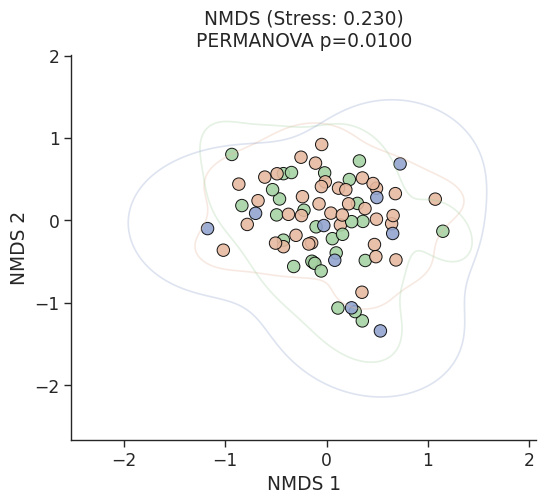

Finish NMDS.


In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
from sklearn.manifold import MDS
import os

INPUT_FILE = "/home/marcos/PRJEB59406/results/Final_Table_Taxonomy_Function.tsv"
OUTPUT_DIR = "/home/marcos/PRJEB59406/figures/pub_quality/"
STATS_FILE = os.path.join(OUTPUT_DIR, "nmds_stats_report.txt")

MY_PALETTE = {
    "Control": "#e7b9a0",                  # NC
    "Atopic_dermatitis_non_lesion": "#a7d3a4", # AD-NL
    "Atopic_dermatitis_lesion": "#92a4cf"   # AD-L
}
ORDER = ["Control", "Atopic_dermatitis_non_lesion", "Atopic_dermatitis_lesion"]
SHORT_LABELS = ["NC", "AD-NL", "AD-L"]

os.makedirs(OUTPUT_DIR, exist_ok=True)

f_stats = open(STATS_FILE, 'w')
def log_stats(text):
    print(text)
    f_stats.write(text + "\n")

log_stats("--- NMDS ANALYSIS REPORT ---")
df = pd.read_csv(INPUT_FILE, sep='\t')

df['Label'] = df.apply(lambda x: x['Species'] if pd.notna(x['Species']) and len(str(x['Species'])) > 3 else f"{x['Genus']} ({x['mag_id']})", axis=1)

matrix = df.pivot_table(index='Sample', columns='Label', values='Abundance', fill_value=0)
sample_to_group = df.drop_duplicates('Sample').set_index('Sample')['Group'].to_dict()
groups = matrix.index.map(sample_to_group)

log_stats("\n=== BETA DIVERSITY (BRAY-CURTIS NMDS) ===")

dist_matrix = pdist(matrix, metric='braycurtis')
dist_square = squareform(dist_matrix)

permanova_title = ""
try:
    from skbio.stats.distance import permanova
    from skbio import DistanceMatrix
    dm = DistanceMatrix(dist_square, ids=matrix.index)
    perm_results = permanova(dm, groups, permutations=999)
    p_val = perm_results['p-value']
    log_stats(f"PERMANOVA: p-value={p_val:.4f}, Pseudo-F={perm_results['test statistic']:.3f}")
    permanova_title = f"\nPERMANOVA p={p_val:.4f}"
except ImportError:
    log_stats("WARNING: skbio not installed. Skipping PERMANOVA.")
except Exception as e:
    log_stats(f"PERMANOVA Error: {e}")

print("Calculating NMDS (may take a moment)...")
# metric=False -> NMDS
nmds = MDS(n_components=2, metric=False, dissimilarity='precomputed', 
           random_state=42, n_init=4, max_iter=300, normalized_stress='auto')

nmds_coords = nmds.fit_transform(dist_square)
stress_value = nmds.stress_ 
log_stats(f"NMDS Stress: {stress_value:.4f}")

nmds_df = pd.DataFrame(nmds_coords, columns=['NMDS1', 'NMDS2'], index=matrix.index)
nmds_df['Group'] = groups

plt.figure(figsize=(6, 5))
sns.set_style("ticks")
sns.set_context("paper", font_scale=1.4)

# Scatterplot
sns.scatterplot(data=nmds_df, x='NMDS1', y='NMDS2', hue='Group', hue_order=ORDER,
                palette=MY_PALETTE, s=80, edgecolor='black', alpha=0.9, legend=False)

for g in ORDER:
    subset = nmds_df[nmds_df['Group'] == g]
    if len(subset) > 3:
        sns.kdeplot(x=subset['NMDS1'], y=subset['NMDS2'], 
                    levels=1, color=MY_PALETTE[g], alpha=0.3)

plt.title(f"NMDS (Stress: {stress_value:.3f}){permanova_title}")
plt.xlabel("NMDS 1")
plt.ylabel("NMDS 2")

sns.despine()
plt.savefig(os.path.join(OUTPUT_DIR, 'Fig1c_NMDS.svg'), bbox_inches='tight')
plt.show()

f_stats.close()
print("Finish NMDS.")